In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from window_generator_nn import WindowGenerator
from nn_models.attention_encoder import AttentionEncoder
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [5]:
m = nn.Conv1d(20, 5, 3, padding='same')
input = torch.randn(8, 20, 3)
output = m(input)
output.shape

torch.Size([8, 5, 1])

In [2]:
N = 300

packetLossRate = np.random.random((N,))
jitter = np.arange(N)
latency = np.random.random((N,))
current = datetime.now()
times = [(current + timedelta(seconds=(i + i % 60 / 60))).strftime("%Y-%m-%d %H:%M:%S.%f") for i in range(N)]

In [3]:
df = pd.DataFrame({
    'packetLossRate': packetLossRate,
    'jitter': jitter,
    'latency': latency,
    'timestamp': pd.to_datetime(times)
})
df

,packetLossRate,jitter,latency,timestamp
0,0.671517,0,0.842370,2022-03-28 21:37:51.645594
1,0.427082,1,0.080448,2022-03-28 21:37:52.662261
2,0.563636,2,0.256195,2022-03-28 21:37:53.678927
3,0.685345,3,0.065770,2022-03-28 21:37:54.695594
4,0.941279,4,0.481241,2022-03-28 21:37:55.712261
...,...,...,...,...
295,0.558418,295,0.530749,2022-03-28 21:42:47.562261
296,0.117846,296,0.109504,2022-03-28 21:42:48.578927
297,0.659283,297,0.779107,2022-03-28 21:42:49.595594
298,0.683380,298,0.542204,2022-03-28 21:42:50.612261


In [4]:
window = WindowGenerator(20, 2, 1, df[:200], df[200:250], df[250:], label_columns=['packetLossRate', 'latency'])
window

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [21 22]
Input column name(s): Index(['packetLossRate', 'jitter', 'latency'], dtype='object')
Label column name(s): ['packetLossRate', 'latency']

In [5]:
model = AttentionEncoder(20, 3, [32, 16], 2, 2)

In [6]:
def plot(self, model, plot_col='packetLossRate', max_subplots=3):
    inputs, labels, indices = next(iter(self.test(batch=max_subplots)))
    indices = indices.numpy().astype('int32')
    
    plt.figure(figsize=(16, 8))
    plot_col_index = self.column_indices[plot_col]
    input_col_index = self.input_columns_indices.get(plot_col, None) if self.input_columns else plot_col_index
    label_col_index = self.label_columns_indices.get(plot_col, None) if self.label_columns else plot_col_index
    assert input_col_index is not None and label_col_index is not None

    name = None
    interval = 5
    for n in range(max_subplots):
        plt.subplot(max_subplots, 1, n+1)
        plt.ylabel(plot_col)
        sub_indices = indices[n, ::interval]
        if n == 0:
            name = self.test_data.time_column.loc[sub_indices][sub_indices[0]].strftime("%Y-%m-%d %H:%M:%S")
        sub_times = [x.strftime("%M:%S.%f")[:-4] for x in self.test_data.time_column[sub_indices]]
        sub_ticks = np.arange(self.total_window_size)[::interval]
        plt.xticks(sub_ticks, sub_times)
        values = inputs[n, :, input_col_index] * self.train_std[plot_col] + self.train_mean[plot_col]
        plt.plot(self.input_indices, values,
                label='Inputs', marker='.', zorder=-10)

        values = labels[n, :, label_col_index] * self.train_std[plot_col] + self.train_mean[plot_col]
        plt.plot(self.label_indices, values,
                    label='Labels', c='#2ca02c')
        if model is not None:
            predictions = model(inputs)
            values = predictions[n, :, label_col_index] * self.train_std[plot_col] + self.train_mean[plot_col]
            values = values.detach().numpy()
            plt.scatter(self.label_indices, values,
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time ' + name + ' [s]')

WindowGenerator.plot = plot

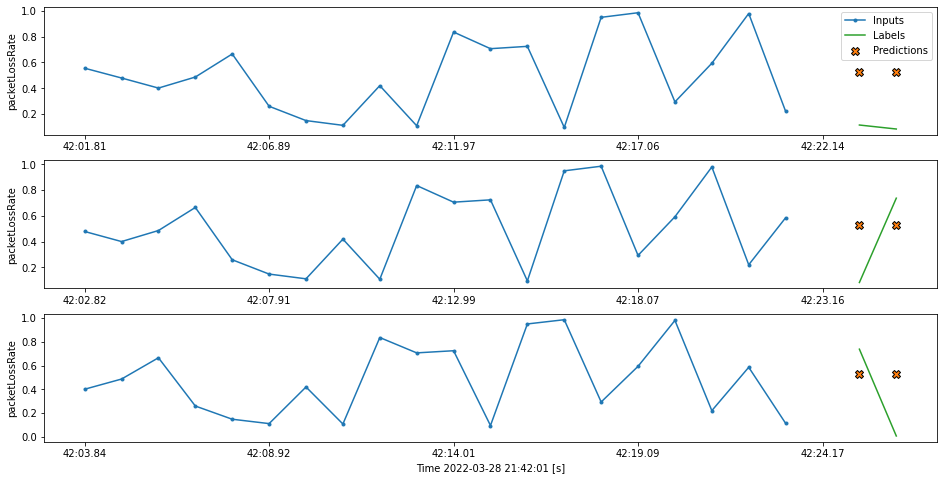

In [8]:
window.plot(model)

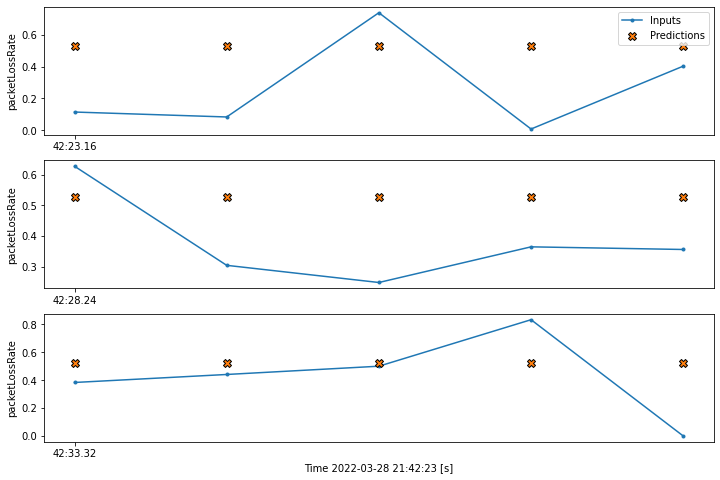

In [11]:
window.plot_y(model, width=5)

In [25]:
x = torch.rand(20, 2, 3)
y = x +  torch.rand(20, 1, 3)
y.shape, nn.BatchNorm1d(2)(y).shape

(torch.Size([20, 2, 3]), torch.Size([20, 2, 3]))